In [1]:
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

import glob
import pickle

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.cluster import KMeans, MiniBatchKMeans

from sklearn.metrics import adjusted_mutual_info_score, homogeneity_score, completeness_score, fowlkes_mallows_score    # Supervised / external metrics
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score    # unsupervised / internal metrics

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Loading

In [2]:
data_root = '/home/c44406/datasets/atb_uofa/loan_portfolio/'

In [3]:
datasets_all = []
for dpath in glob.glob(f'{data_root}datasetv6*.csv'):
    df = pd.read_csv(dpath, dtype={'dunning_level':'object'})
    datasets_all.append(df)

datasets = pd.concat(datasets_all, axis=0, ignore_index=True)

### Preview

In [4]:
datasets.head()

,bus_ptnr_group,cal_day,naics_id,BRR,BEACON,dunning_level_code,dunning_level,days_in_arrears,impaired,Oustanding_principle_on_posting_date,percentage_rate,transactions,abs_transactions,transactions_db,transactions_cr,n_transactions,SUB_SYSTEM_DP,SUB_SYSTEM_FD,SUB_SYSTEM_IN,SUB_SYSTEM_LN,SUB_SYSTEM_RF,SUB_SYSTEM_RP,SUB_SYSTEM_SP,SUB_SYSTEM_TF,transaction_type_Loan_Disbursement,transaction_type_Payment_Distrib_Loan,transaction_type_Loan_Payment,transaction_type_Bank_Trsf_Deposit_Acct,transaction_type_Installment_Payment,transaction_type_Transfer,transaction_type_Direct_Deposit,transaction_type_Cheque,transaction_type_Deposit_Cheque,transaction_type_Incoming_Wire,transaction_type_Auto_LOC_Repayment,transaction_type_Outgoing_Wire,transaction_type_EFT_Settlement,transaction_type_Direct_Debit,transaction_type_Overdraft_Transfer,transaction_type_Customer_Transfer,transaction_type_LOC_Disburse_RealTime_Adv,transaction_type_Loan_Transfer,transaction_type_EOD_ODP_Trf_Funded_Acc,transaction_type_misc,ALL_total_assets,ALL_total_cur_liabs,ALL_accts_pay,ALL_dscr,ALL_cp_ltd,CORP_gross_income,CORP_net_cash_income,CORP_income_before_tax,CORP_net_income,CORP_net_income_growth,AGRI_gross_farming_inc,AGRI_net_farm_inc,mth_since_brr_update,defaults_3_months,defaults_6_months,defaults_9_months,defaults_12_months,has_loan
0,770958,2013-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,394.08,83243.78,41818.93,41424.85,98.0,55375.52,0.0,0.0,27868.26,0.0,0.0,0.0,0.0,0.0,256.54,256.54,0.0,221.54,0.0,0.00,4037.86,14463.75,0.0,28709.44,0.0,2745.62,878.98,5109.42,0.0,7377.96,7377.96,5109.42,6698.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,181448,2013-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3447.19,67485.93,32019.37,35466.56,82.0,46268.51,0.0,0.0,21217.42,0.0,0.0,0.0,0.0,0.0,968.48,956.48,0.0,956.48,0.0,365.29,13107.72,11793.86,0.0,14241.44,0.0,0.00,795.26,8373.64,0.0,2428.90,2428.90,8373.64,2545.84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,395339,2015-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-13386.23,101867.77,44240.77,57627.00,48.0,94700.91,0.0,0.0,7166.86,0.0,0.0,0.0,0.0,0.0,87.05,2.50,0.0,2.50,0.0,0.00,29439.45,37248.01,0.0,3539.08,0.0,0.00,44.50,5046.62,0.0,2.50,2.50,5046.62,21326.27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,386265,2014-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-44987.63,1011278.75,483145.56,528133.19,204.0,753442.98,0.0,0.0,257835.77,0.0,0.0,0.0,0.0,0.0,326.46,287.96,0.0,287.96,0.0,83794.10,229876.06,142168.60,0.0,211548.34,0.0,0.00,17004.15,141424.34,0.0,9331.42,9331.42,141424.34,13490.59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,634872,2017-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,821.90,11822.50,6322.20,5500.30,24.0,7416.92,0.0,0.0,4405.58,0.0,0.0,0.0,0.0,0.0,424.28,424.28,0.0,399.28,0.0,0.00,0.00,2265.18,0.0,3530.36,0.0,0.00,0.00,19.00,0.0,924.28,924.28,19.00,2892.56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,False


In [5]:
datasets.shape

(2058256, 62)

In [6]:
# non float64
tmp = datasets.dtypes
tmp[tmp != 'float64']

bus_ptnr_group     int64
cal_day           object
dunning_level     object
has_loan            bool
dtype: object

In [7]:
# range of calendar
datasets.sort_values('cal_day')['cal_day']

66711      2008-06-30
751020     2008-07-31
1462566    2008-07-31
761632     2008-07-31
1463539    2008-12-31
              ...    
679248     9999-04-30
1748139    9999-04-30
1278118    9999-12-31
2057760    9999-12-31
1881949    9999-12-31
Name: cal_day, Length: 2058256, dtype: object

In [8]:
# proportion of missing values
pd.DataFrame(dict(zip(datasets.columns, datasets.isna().to_numpy().sum(axis=0) / len(datasets))), index=[0])

,bus_ptnr_group,cal_day,naics_id,BRR,BEACON,dunning_level_code,dunning_level,days_in_arrears,impaired,Oustanding_principle_on_posting_date,percentage_rate,transactions,abs_transactions,transactions_db,transactions_cr,n_transactions,SUB_SYSTEM_DP,SUB_SYSTEM_FD,SUB_SYSTEM_IN,SUB_SYSTEM_LN,SUB_SYSTEM_RF,SUB_SYSTEM_RP,SUB_SYSTEM_SP,SUB_SYSTEM_TF,transaction_type_Loan_Disbursement,transaction_type_Payment_Distrib_Loan,transaction_type_Loan_Payment,transaction_type_Bank_Trsf_Deposit_Acct,transaction_type_Installment_Payment,transaction_type_Transfer,transaction_type_Direct_Deposit,transaction_type_Cheque,transaction_type_Deposit_Cheque,transaction_type_Incoming_Wire,transaction_type_Auto_LOC_Repayment,transaction_type_Outgoing_Wire,transaction_type_EFT_Settlement,transaction_type_Direct_Debit,transaction_type_Overdraft_Transfer,transaction_type_Customer_Transfer,transaction_type_LOC_Disburse_RealTime_Adv,transaction_type_Loan_Transfer,transaction_type_EOD_ODP_Trf_Funded_Acc,transaction_type_misc,ALL_total_assets,ALL_total_cur_liabs,ALL_accts_pay,ALL_dscr,ALL_cp_ltd,CORP_gross_income,CORP_net_cash_income,CORP_income_before_tax,CORP_net_income,CORP_net_income_growth,AGRI_gross_farming_inc,AGRI_net_farm_inc,mth_since_brr_update,defaults_3_months,defaults_6_months,defaults_9_months,defaults_12_months,has_loan
0,0.0,0.0,0.23856,0.23856,0.955958,0.752335,0.9617,0.754198,0.23856,0.23856,0.23856,0.065637,0.065637,0.065637,0.065637,0.065637,0.065637,0.065637,0.065637,0.065637,0.065637,0.065637,0.065637,0.065637,0.065637,0.065637,0.065637,0.065637,0.065637,0.065637,0.065637,0.065637,0.065637,0.065637,0.065637,0.065637,0.065637,0.065637,0.065637,0.065637,0.065637,0.065637,0.065637,0.065637,0.514138,0.514138,0.514138,0.514138,0.514138,0.514138,0.514138,0.514138,0.514138,0.514138,0.514138,0.514138,0.23856,0.214896,0.194432,0.175716,0.158415,0.0


## Cleaning

In [4]:
start_date = '2008-01-31'
end_date = '2021-09-30'


cols = datasets.columns

# non-feature columns
other_cols = [
    'bus_ptnr_group',
     'cal_day',
     'naics_id',
     'has_loan'
]


used_cols = cols.str.startswith((
    'BRR', 
    'impaired', 
    'Oustanding_principle_on_posting_date', 
    'percentage_rate', 
    'abs_transactions', 
    'n_transactions', 
    'mth_since_brr_update', 
#     'defaults', 
    'transactions', 
    'SUB_SYSTEM', 
    'transaction_type'
))
used_cols = cols[used_cols].to_list()

In [5]:
data = datasets[other_cols + used_cols].copy()
data['cal_day'] = pd.to_datetime(data['cal_day'], errors='coerce')
data = data[data['cal_day'].notnull()].copy()
data.replace(to_replace=[np.inf, -np.inf], value=[np.nan, np.nan], inplace=True)
data = data[data['cal_day'] >= start_date].copy()
data = data[data['cal_day'] <= end_date].copy()

In [6]:
ppl = Pipeline(steps=[
    ('masking', SimpleImputer(verbose=100)),
    ('scaling', PowerTransformer())
])

transformer = ColumnTransformer(transformers=[
    ('features', ppl, used_cols)
])

data[used_cols] = transformer.fit_transform(data)

In [7]:
data.isna().to_numpy().sum(axis=0)

array([     0,      0, 490937,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0])

In [8]:
data.to_pickle('transformed.pkl')

## PCA

In [47]:
data = pd.read_pickle('transformed.pkl')

In [48]:
data = data[data['has_loan'] == 1].copy()
data.sort_values('cal_day').head()

,bus_ptnr_group,cal_day,naics_id,has_loan,BRR,impaired,Oustanding_principle_on_posting_date,percentage_rate,transactions,abs_transactions,transactions_db,transactions_cr,n_transactions,SUB_SYSTEM_DP,SUB_SYSTEM_FD,SUB_SYSTEM_IN,SUB_SYSTEM_LN,SUB_SYSTEM_RF,SUB_SYSTEM_RP,SUB_SYSTEM_SP,SUB_SYSTEM_TF,transaction_type_Loan_Disbursement,transaction_type_Payment_Distrib_Loan,transaction_type_Loan_Payment,transaction_type_Bank_Trsf_Deposit_Acct,transaction_type_Installment_Payment,transaction_type_Transfer,transaction_type_Direct_Deposit,transaction_type_Cheque,transaction_type_Deposit_Cheque,transaction_type_Incoming_Wire,transaction_type_Auto_LOC_Repayment,transaction_type_Outgoing_Wire,transaction_type_EFT_Settlement,transaction_type_Direct_Debit,transaction_type_Overdraft_Transfer,transaction_type_Customer_Transfer,transaction_type_LOC_Disburse_RealTime_Adv,transaction_type_Loan_Transfer,transaction_type_EOD_ODP_Trf_Funded_Acc,transaction_type_misc,mth_since_brr_update
1327691,315757,2012-01-31,111190.0,True,0.868297,-0.556678,0.457500,0.334439,0.002794,1.294558,1.258266,1.296445,0.459906,0.988967,3.537966,3.462281,1.457309,3.765021,3.678037,3.683163,3.651025,2.450809,1.671021,1.605765,2.692965,1.619145,1.458472,1.161136,0.997018,1.132393,3.054739,1.387085,3.083962,2.254734,1.10055,1.457789,3.518164,1.373622,1.390126,1.443737,1.25245,0.006136
633758,830939,2012-01-31,441310.0,True,1.975557,-0.556678,0.244285,0.847346,0.002794,1.294558,1.258266,1.296445,0.459906,0.988967,3.537966,3.462281,1.457309,3.765021,3.678037,3.683163,3.651025,2.450809,1.671021,1.605765,2.692965,1.619145,1.458472,1.161136,0.997018,1.132393,3.054739,1.387085,3.083962,2.254734,1.10055,1.457789,3.518164,1.373622,1.390126,1.443737,1.25245,0.006136
638108,881983,2012-01-31,238910.0,True,0.868297,-0.556678,-0.736319,-2.069011,0.002794,1.294558,1.258266,1.296445,0.459906,0.988967,3.537966,3.462281,1.457309,3.765021,3.678037,3.683163,3.651025,2.450809,1.671021,1.605765,2.692965,1.619145,1.458472,1.161136,0.997018,1.132393,3.054739,1.387085,3.083962,2.254734,1.10055,1.457789,3.518164,1.373622,1.390126,1.443737,1.25245,0.006136
640806,392527,2012-01-31,531190.0,True,1.975557,-0.556678,0.230360,0.046759,0.002794,1.294558,1.258266,1.296445,0.459906,0.988967,3.537966,3.462281,1.457309,3.765021,3.678037,3.683163,3.651025,2.450809,1.671021,1.605765,2.692965,1.619145,1.458472,1.161136,0.997018,1.132393,3.054739,1.387085,3.083962,2.254734,1.10055,1.457789,3.518164,1.373622,1.390126,1.443737,1.25245,0.006136
639218,414277,2012-01-31,112991.0,True,-0.393313,-0.556678,-0.241443,0.046746,0.002794,1.294558,1.258266,1.296445,0.459906,0.988967,3.537966,3.462281,1.457309,3.765021,3.678037,3.683163,3.651025,2.450809,1.671021,1.605765,2.692965,1.619145,1.458472,1.161136,0.997018,1.132393,3.054739,1.387085,3.083962,2.254734,1.10055,1.457789,3.518164,1.373622,1.390126,1.443737,1.25245,0.006136


In [10]:
data = data.drop('has_loan', axis=1).copy()

In [11]:
other_cols = [
    'bus_ptnr_group',
     'cal_day',
     'naics_id'
]

used_cols = data.columns.difference(other_cols).to_list()
len(used_cols)

38

In [12]:
ppl_pca = Pipeline(steps=[
    ('masking', SimpleImputer(strategy='constant', fill_value=0.0))
])

transformer_pca = ColumnTransformer(transformers=[
    ('numeric', ppl_pca, used_cols)
])


data[used_cols] = transformer_pca.fit_transform(data)

### Performance of PCA

In [19]:
full_pca = PCA(n_components=38, svd_solver='randomized', iterated_power='auto', random_state=3024)
full_pca.fit(data[used_cols].to_numpy())
# sg_vectors = full_pca.components_
full_expl_var = full_pca.explained_variance_

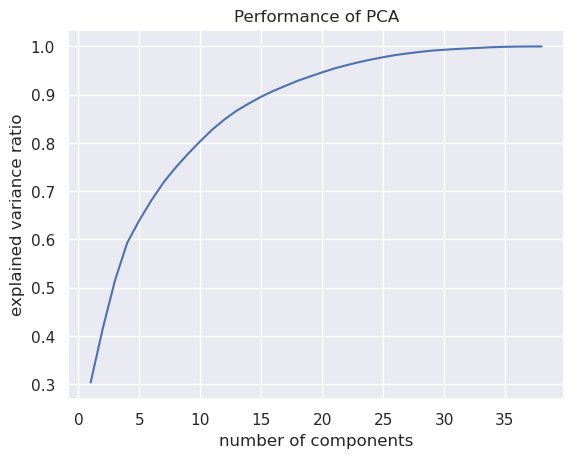

In [20]:
sns.set(style='darkgrid')

expl_vars = np.cumsum(full_expl_var)
expl_var_ratios = expl_vars / expl_vars[-1]

fig, ax = plt.subplots(1)
ax.plot(np.arange(1,39), expl_var_ratios)
ax.set_title('Performance of PCA')
ax.set_xlabel('number of components')
ax.set_ylabel('explained variance ratio')
plt.show()

### 

In [14]:
pca = PCA(n_components=35, svd_solver='randomized', iterated_power='auto', random_state=3024)
pca.fit(data[used_cols].to_numpy())

print(f"explained variance ratio is {sum(pca.explained_variance_ratio_):.2f}")

explained variance ratio is 1.00


In [15]:
reduced_data = pca.transform(data[used_cols].to_numpy())

In [16]:
np.save('reduced_data.npy', reduced_data)

## KMeans

In [2]:
reduced_data = np.load('reduced_data.npy')

In [18]:
%%time

kmeans = KMeans(n_clusters=10, random_state=3024)
kmeans.fit(reduced_data)

CPU times: user 3min 39s, sys: 55.1 s, total: 4min 34s
Wall time: 50.5 s


KMeans(n_clusters=10, random_state=3024)

In [19]:
print(f"inertia is {kmeans.inertia_:.3E}")

inertia is 2.323E+07


In [3]:
kmeans = KMeans(n_clusters=10)
kmeans.fit(reduced_data)
labels_pred = kmeans.labels_

In [ ]:
score = silhouette_score(reduced_data, labels_pred, metric='euclidean')
print(f"Silhouette Coefficient is {score:.3}")

In [42]:
score = calinski_harabasz_score(reduced_data, labels_pred)
print(f"Calinski-Harabasz Index is {score:.3E}")

Calinski-Harabasz Index is 1.981E+05


In [4]:
score = davies_bouldin_score(reduced_data, labels_pred)
print(f"Davies-Bouldin Index is {score:.3}")

Davies-Bouldin Index is 1.54


In [22]:
# Refit KMeans with random initialization
scores = []

for i in range(10):
    kmeans.fit(reduced_data)
    scores.append(adjusted_mutual_info_score(labels_pred, kmeans.labels_))
    labels_pred = kmeans.labels_

print(np.mean(scores))

0.8127953833674624


In [5]:
labels_pred = kmeans.labels_
centroids = kmeans.cluster_centers_

In [6]:
# Refit KMeans with previous cluster centroids
scores = []

for i in range(10):
    kmeans_ini = KMeans(n_clusters=10, init=centroids, n_init=1)
    kmeans_ini.fit(reduced_data)
    scores.append(adjusted_mutual_info_score(labels_pred, kmeans_ini.labels_))
    labels_pred = kmeans_ini.labels_
    centroids = kmeans_ini.cluster_centers_
    
print(np.mean(scores))

0.9996242192639647


## Mini-Batch KMeans

In [28]:
%%time

seq_kmeans = MiniBatchKMeans(n_clusters=10, batch_size=512, random_state=3024)
seq_kmeans.fit(reduced_data)

CPU times: user 2.65 s, sys: 1.01 s, total: 3.66 s
Wall time: 1.11 s


MiniBatchKMeans(batch_size=512, n_clusters=10, random_state=3024)

In [29]:
print(f"inertia is {seq_kmeans.inertia_:.3E}")

inertia is 2.359E+07


In [34]:
seq_kmeans = MiniBatchKMeans(n_clusters=10, batch_size=512)
seq_kmeans.fit(reduced_data)
labels_pred = seq_kmeans.labels_

In [ ]:
score = silhouette_score(reduced_data, labels_pred, metric='euclidean')
print(f"Silhouette Coefficient is {score:.3}")

In [40]:
score = calinski_harabasz_score(reduced_data, labels_pred)
print(f"Calinski-Harabasz Index is {score:.3E}")

Calinski-Harabasz Index is 1.883E+05


In [38]:
score = davies_bouldin_score(reduced_data, labels_pred)
print(f"Davies-Bouldin Index is {score:.3}")

Davies-Bouldin Index is 1.69


In [32]:
# Refit KMeans with random initialization
scores = []

for i in range(10):
    seq_kmeans.fit(reduced_data)
    scores.append(adjusted_mutual_info_score(labels_pred, seq_kmeans.labels_))
    labels_pred = seq_kmeans.labels_

print(np.mean(scores))

0.674116672927392


In [33]:
# using partial fit instead
scores = []

for i in range(10):
    seq_kmeans.partial_fit(reduced_data)
    scores.append(adjusted_mutual_info_score(labels_pred, seq_kmeans.labels_))
    labels_pred = seq_kmeans.labels_

print(np.mean(scores))

0.9725039516519957
